### Reranking 예시

In [11]:
from clipmodel import *
import cv2 
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
### https://drive.google.com/file/d/1rhdXSDm14CylgwXHvQhYPdLv_msoDAl5/view?usp=sharing ###
model = torch.load('fashionclip_fn.pt')

In [3]:
### Text, Image processor 정의 ### 
tokenizer = AutoTokenizer.from_pretrained("monologg/distilkobert")
transform = A.Compose([A.Resize(224, 224), ToTensorV2()])

In [4]:
### 예시 text, image 가져오기 ### 

baseline_dir = "./data"
image_dir = os.path.join(baseline_dir, "cropped_train_img")
text_dir = os.path.join(baseline_dir, "train_label")
images = sorted([os.path.join(image_dir, i) for i in os.listdir(image_dir)])
text_pre = sorted([os.path.join(text_dir, i) for i in os.listdir(text_dir)])

val_text_dir = os.path.join(baseline_dir, "cropped_img_selected/val_label")
val_img_dir = os.path.join(baseline_dir, "cropped_img_selected/val_img")
val_text_pre = sorted(
    [os.path.join(val_text_dir, i) for i in os.listdir(val_text_dir)]
)[1:]
val_images = sorted([os.path.join(val_img_dir, i) for i in os.listdir(val_img_dir)])

texts = []
print("Extracting text information!")
for i in tqdm(range(len(text_pre))):
    with open(text_pre[i], "r", encoding="utf-8") as f:
        te = f.read()
        texts.append(te)

val_texts = []
for i in tqdm(range(len(val_text_pre))):
    with open(val_text_pre[i], "r", encoding="utf-8") as f:
        te = f.read()
        val_texts.append(te)

Extracting text information!


100%|██████████| 11899/11899 [00:00<00:00, 52347.58it/s]


In [5]:
### 예시: DALL-E에 들어가는 문장: 
val_texts[0]

'스타일에서 스타일은 스트리트이다. 하의에서 기장은 발목이다. 하의에서 색상은 네이비이다. 하의에서 카테고리는 청바지이다. 하의에서 디테일에는 디스트로이드이다. 하의에서 소재에는 데님이다. 하의에서 프린트에는 무지이다. 하의에서 핏은 노멀이다. 상의에서 색상은 화이트이다. 상의에서 서브색상은 네이비이다. 상의에서 카테고리는 티셔츠이다. 상의에서 디테일에는 드롭숄더이다. 상의에서 소매기장은 반팔이다. 상의에서 소재에는 저지이다. 상의에서 프린트에는 레터링이다. 상의에서 핏은 오버사이즈이다.'

In [6]:
### Image Inputs ###
### 예시: DALL-E가 위의 text에 대해 생성해내는 이미지가 5개라고 할때:
### transform으로 224 x 224, ToTensorV2 형식으로 변환, 하나의 tensor로 stack
test_images = []
for im in val_images[:5]:
    single_im = cv2.imread(im)
    single_im = cv2.cvtColor(single_im, cv2.COLOR_BGR2RGB)
    ima = transform(image=single_im)['image']
    test_images.append(ima.float())
test_images = torch.stack(test_images, dim = 0)

In [7]:
### Text Input ###
input_texts = tokenizer(val_texts[0], padding=True, pad_to_max_length=True, max_length = 128, truncation=True, return_tensors = "pt")

/opt/conda/envs/lightweight/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2233: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


In [8]:
device = torch.device("cuda")
model = model.to(device)
input_texts = input_texts.to(device)
test_images = test_images.to(device)

In [9]:
with torch.no_grad():
    model.eval()
    ### Input text 1개, DALL-E 가 만들어낸 test_images 5개 ###
    text_embeds, image_embeds = model(input_texts, test_images)
    lgits = (text_embeds @ image_embeds.T)

Input Text: 스타일에서 스타일은 스트리트이다. 하의에서 기장은 발목이다. 하의에서 색상은 네이비이다. 하의에서 카테고리는 청바지이다. 하의에서 디테일에는 디스트로이드이다. 하의에서 소재에는 데님이다. 하의에서 프린트에는 무지이다. 하의에서 핏은 노멀이다. 상의에서 색상은 화이트이다. 상의에서 서브색상은 네이비이다. 상의에서 카테고리는 티셔츠이다. 상의에서 디테일에는 드롭숄더이다. 상의에서 소매기장은 반팔이다. 상의에서 소재에는 저지이다. 상의에서 프린트에는 레터링이다. 상의에서 핏은 오버사이즈이다.
probability: 1.0


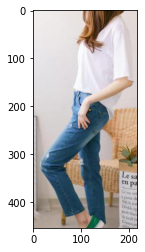

probability: 4.001023068411769e-09


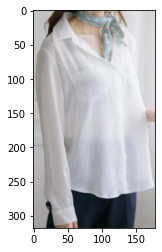

probability: 8.19589079763261e-17


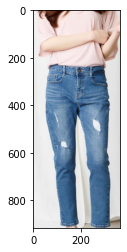

probability: 3.247010050923288e-22


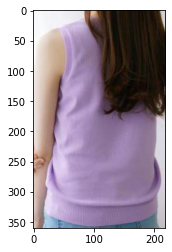

probability: 9.702122619817867e-26


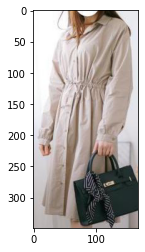

In [12]:
### Re-Ranking 결과 ### 
probs = torch.nn.Softmax(dim=1)(lgits)
import matplotlib.pyplot as plt
print(f'Input Text: {val_texts[0]}')
### Sorting 통해 text랑 image사이 거리가 가장 가까운 순으로 출력 ### 
for idx, prob in sorted(enumerate(probs[0]),key = lambda x: x[1], reverse = True):
    print(f'probability: {prob.item()}')
    tmp = Image.open(val_images[idx])
    plt.imshow(tmp)
    plt.show()